# Exploratory Data Analysis

## Steps:
1. Data Overview
2. Videos Analysis
3. User-Item Interactions

## Loading the dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

train_data = pd.read_csv("dataset/kuairec/data/big_matrix.csv")
test_data = pd.read_csv("dataset/kuairec/data/small_matrix.csv")
categories = pd.read_csv("dataset/kuairec/data/item_categories.csv")
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
train_data = train_data[train_data["timestamp"] >= 0]
test_data = test_data[test_data["timestamp"] >= 0]

# Construct item feature matrix
items = train_data.groupby("video_id")
items = items.agg(
    {
        "user_id": "count",
        "video_duration": "mean",
        "timestamp": "max",
        "watch_ratio": "mean",
        "time": "max",
        "date": "max",
    }
)
items.drop(columns=["user_id"], inplace=True)
items.drop(columns=["timestamp"], inplace=True)
items.drop(columns=["watch_ratio"], inplace=True)
items.drop(columns=["date"], inplace=True)
users = train_data.groupby("user_id")
users = users.agg(
    {
        "video_id": "count",
        "timestamp": "max",
        "watch_ratio": "mean",
        "time": "max",
        "date": "max",
    }
)

categories =  pd.read_csv("dataset/kuairec/data/item_categories.csv")

import ast

for i in range (31):
    categories['category_' + str(i)] = 0

categories['feat'] = categories['feat'].apply(ast.literal_eval)
for index, row in categories.iterrows():
    # Get the list of features for the current row
    features = row['feat']

    # Set the corresponding category columns to 1
    for feat in features:
        col_name = f'category_{feat}'
        if col_name in categories.columns:
            categories.at[index, col_name] = 1
categories.drop(columns=['feat'], inplace=True)

# count the number of cols containing category_

category_cols = [col for col in categories.columns if col.startswith('category_')]
num_category_cols = len(category_cols)


## 1.Data Overview

In [2]:
print("Dataset Overview:")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Number of unique users in train: {train_data['user_id'].nunique()}")
print(f"Number of unique videos in train: {train_data['video_id'].nunique()}")
print(f"Number of unique categories: {num_category_cols}")


print("\nSample of training data:")
train_data.head()

Dataset Overview:
Train data shape: (11564987, 8)
Test data shape: (4494578, 8)
Number of unique users in train: 7176
Number of unique videos in train: 10728
Number of unique categories: 31

Sample of training data:


,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


## 2.Videos Analysis

Mean video duration: 12628.143503685964
Median video duration: 9182.203389830509


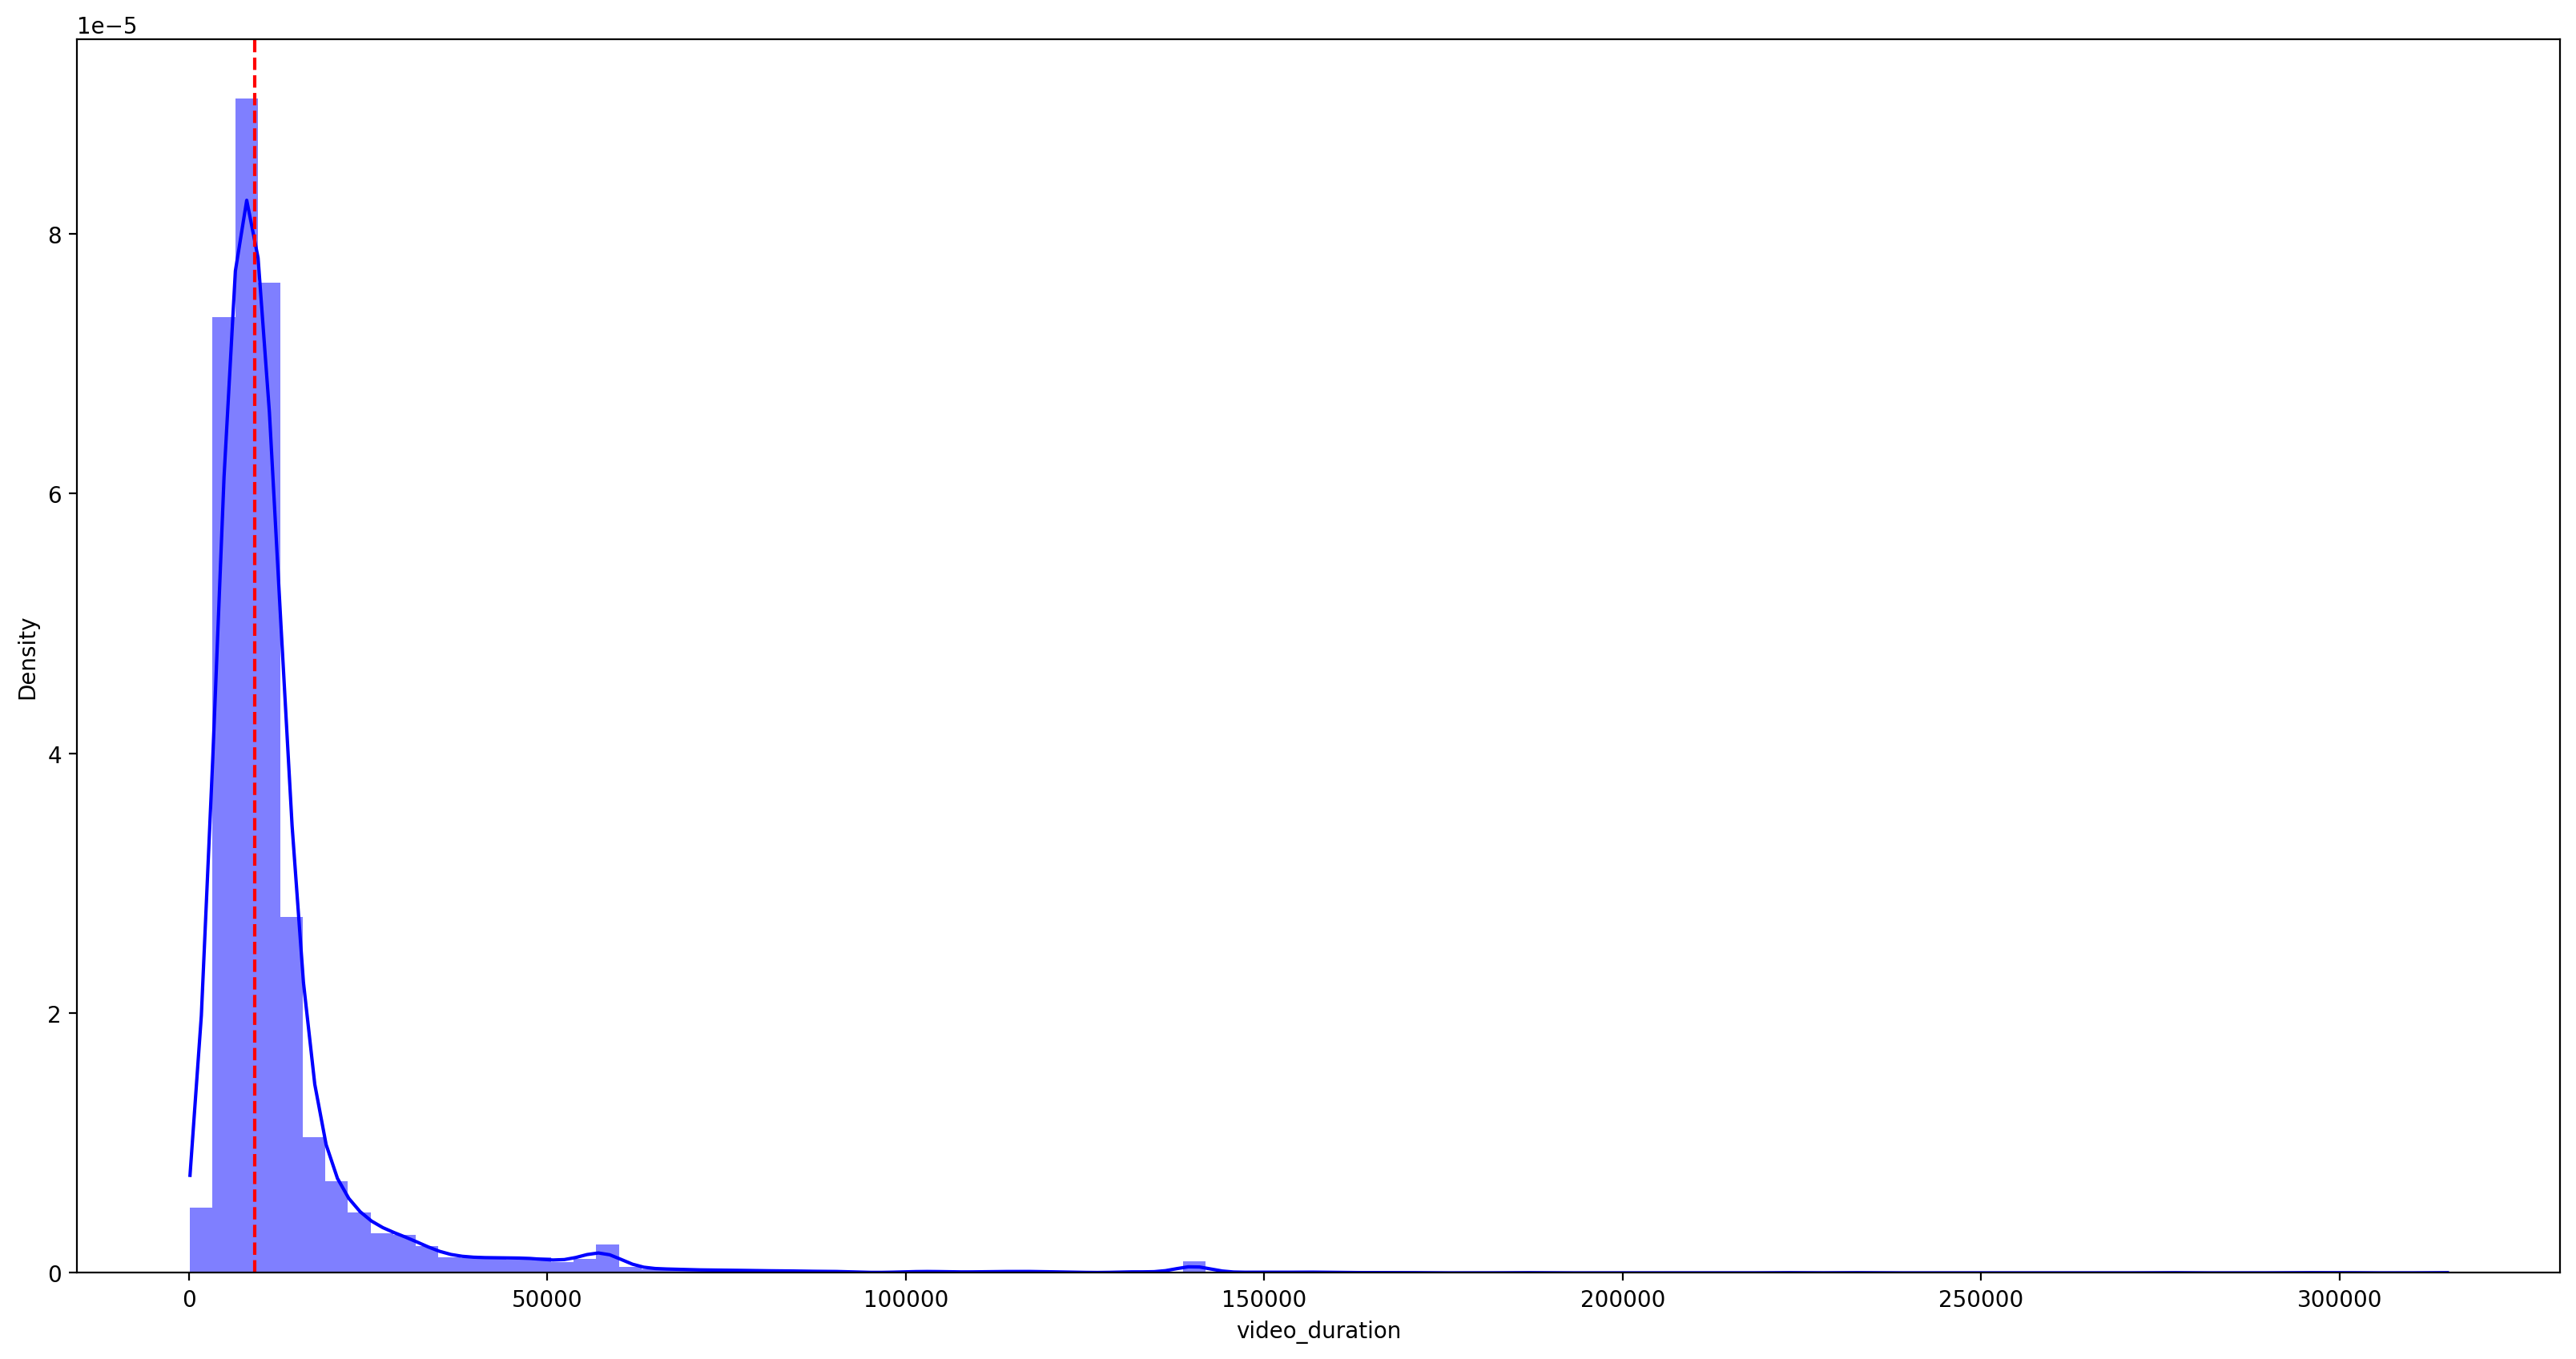

In [3]:
# distribution of video duration
plt.figure(figsize=(20, 10))
sns.histplot(
    items["video_duration"],
    bins=100,
    kde=True,
    color="blue",
    stat="density",
    linewidth=0,
)

# median
plt.axvline(
    items["video_duration"].median(),
    color="red",
    linestyle="--",
    label="Median",
)

# calculate mean and median
mean = items["video_duration"].mean()
median = items["video_duration"].median()
print(f"Mean video duration: {mean}")
print(f"Median video duration: {median}")

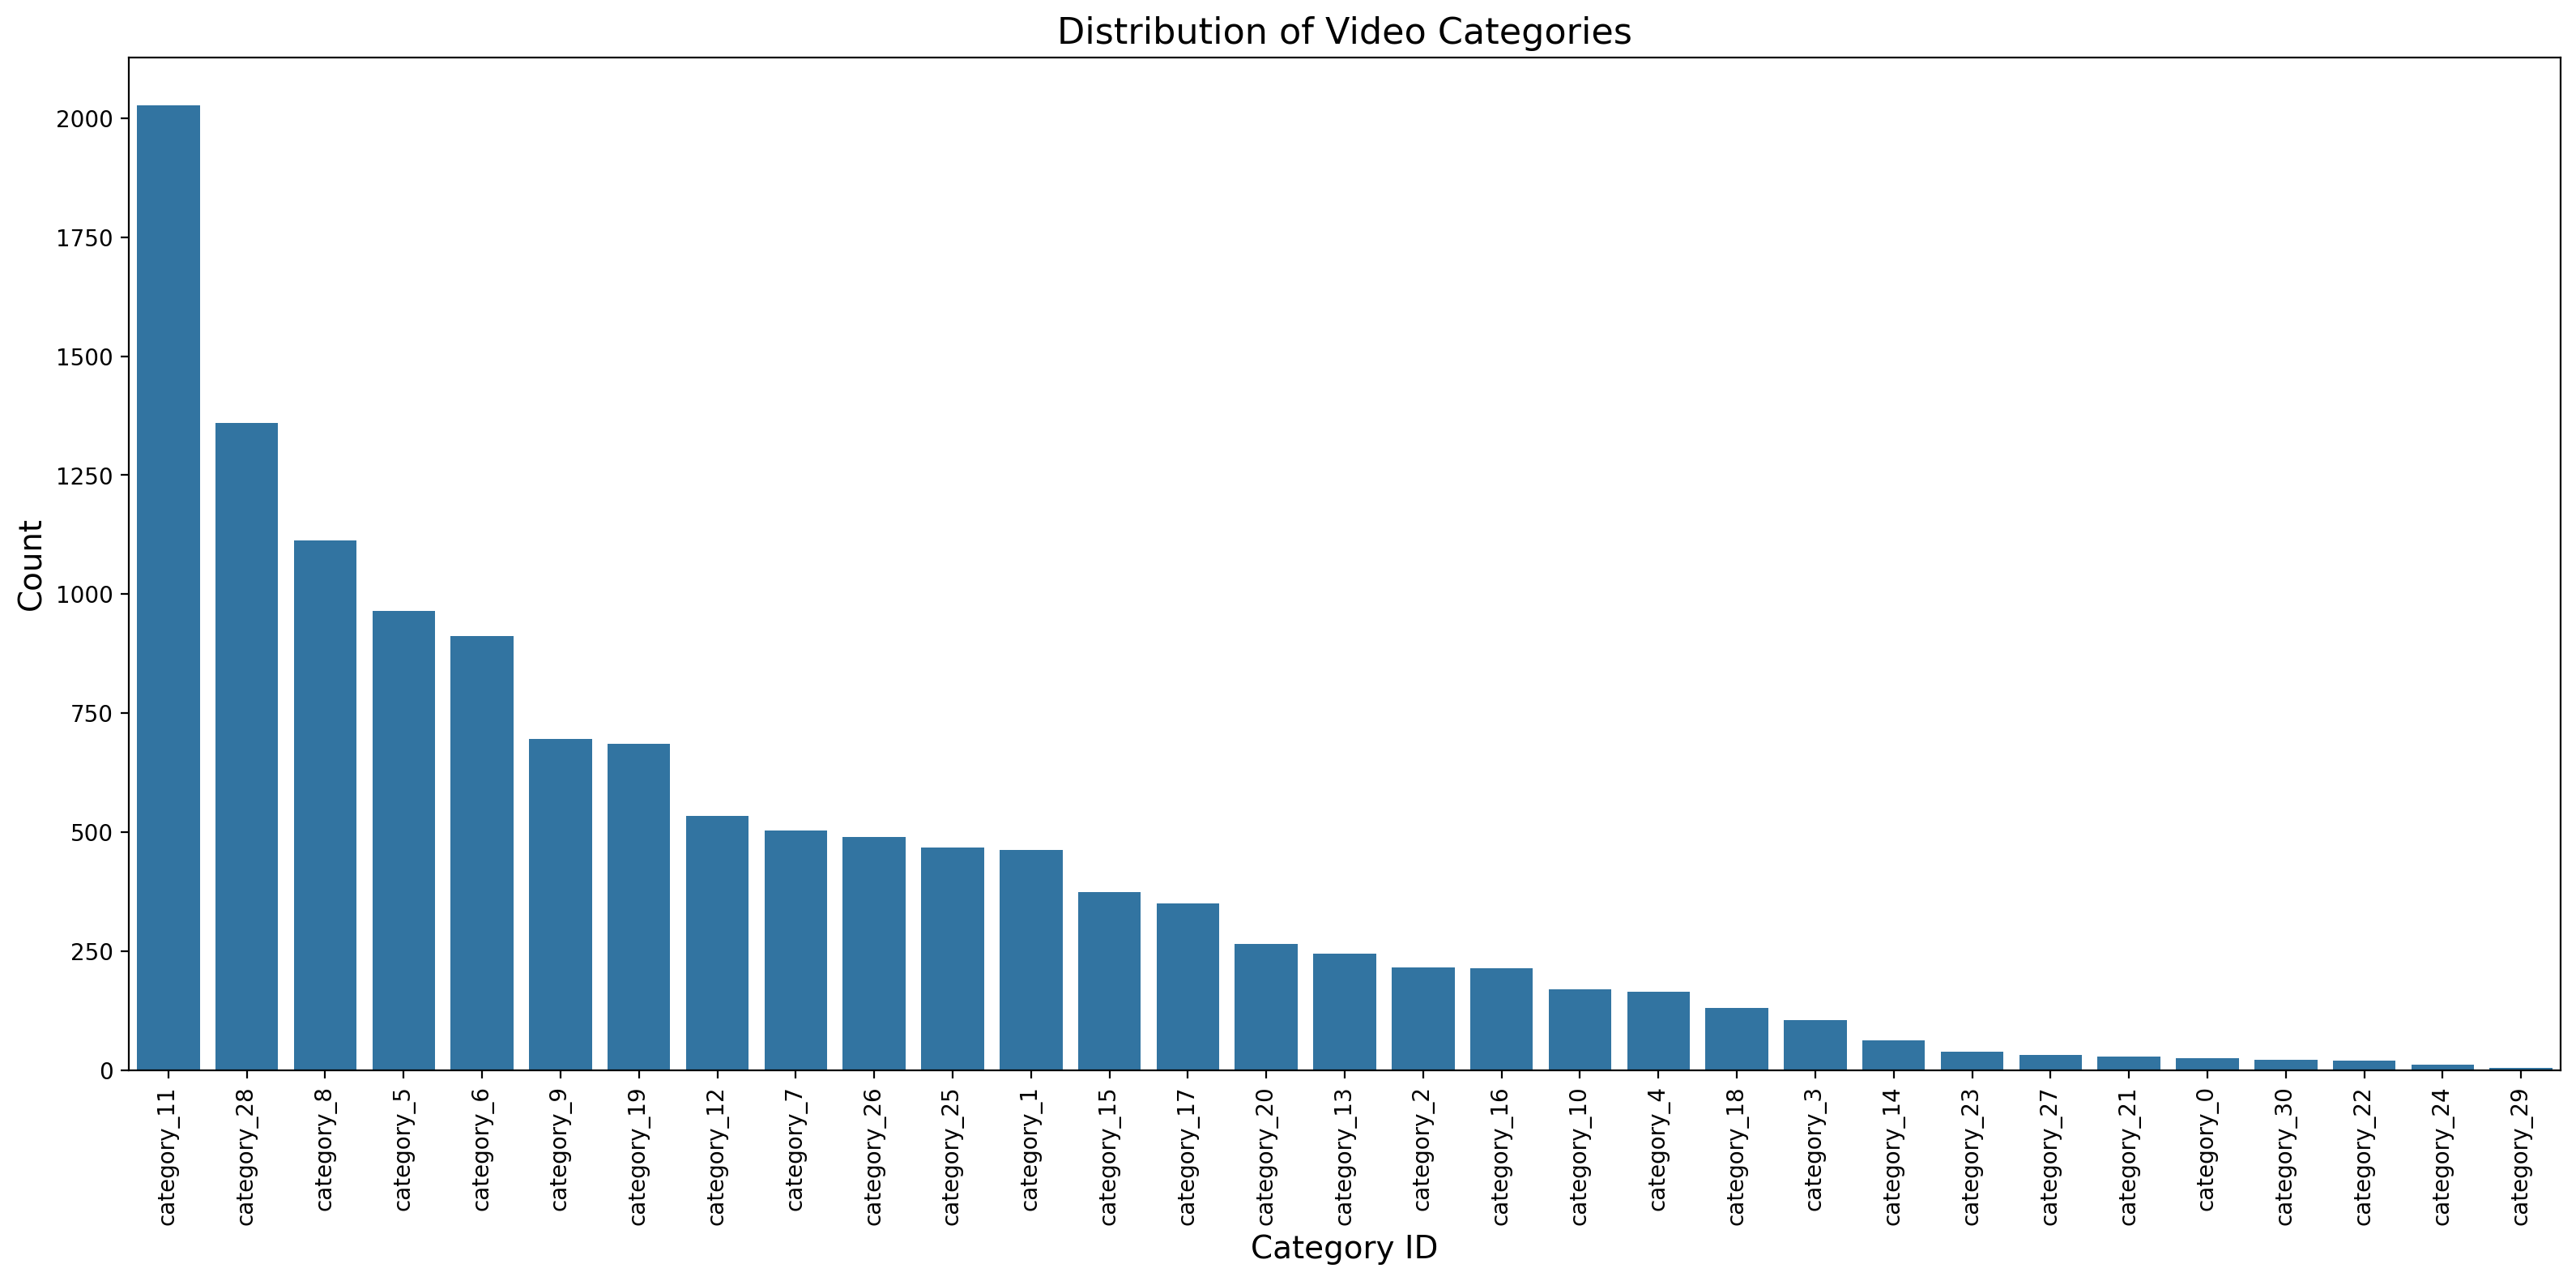

Top 5 most popular categories:
category_11: 2027 videos
category_28: 1360 videos
category_8: 1112 videos
category_5: 964 videos
category_6: 912 videos


In [4]:
# Video Category Distribution
plt.figure(figsize=(16, 8))
category_counts = categories.iloc[:, 1:].sum().sort_values(ascending=False)
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Video Categories', fontsize=16)
plt.xlabel('Category ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Top 5 most popular categories:")
for cat, count in category_counts.head(5).items():
    print(f"{cat}: {count} videos")

## 3. User-Item Interactions

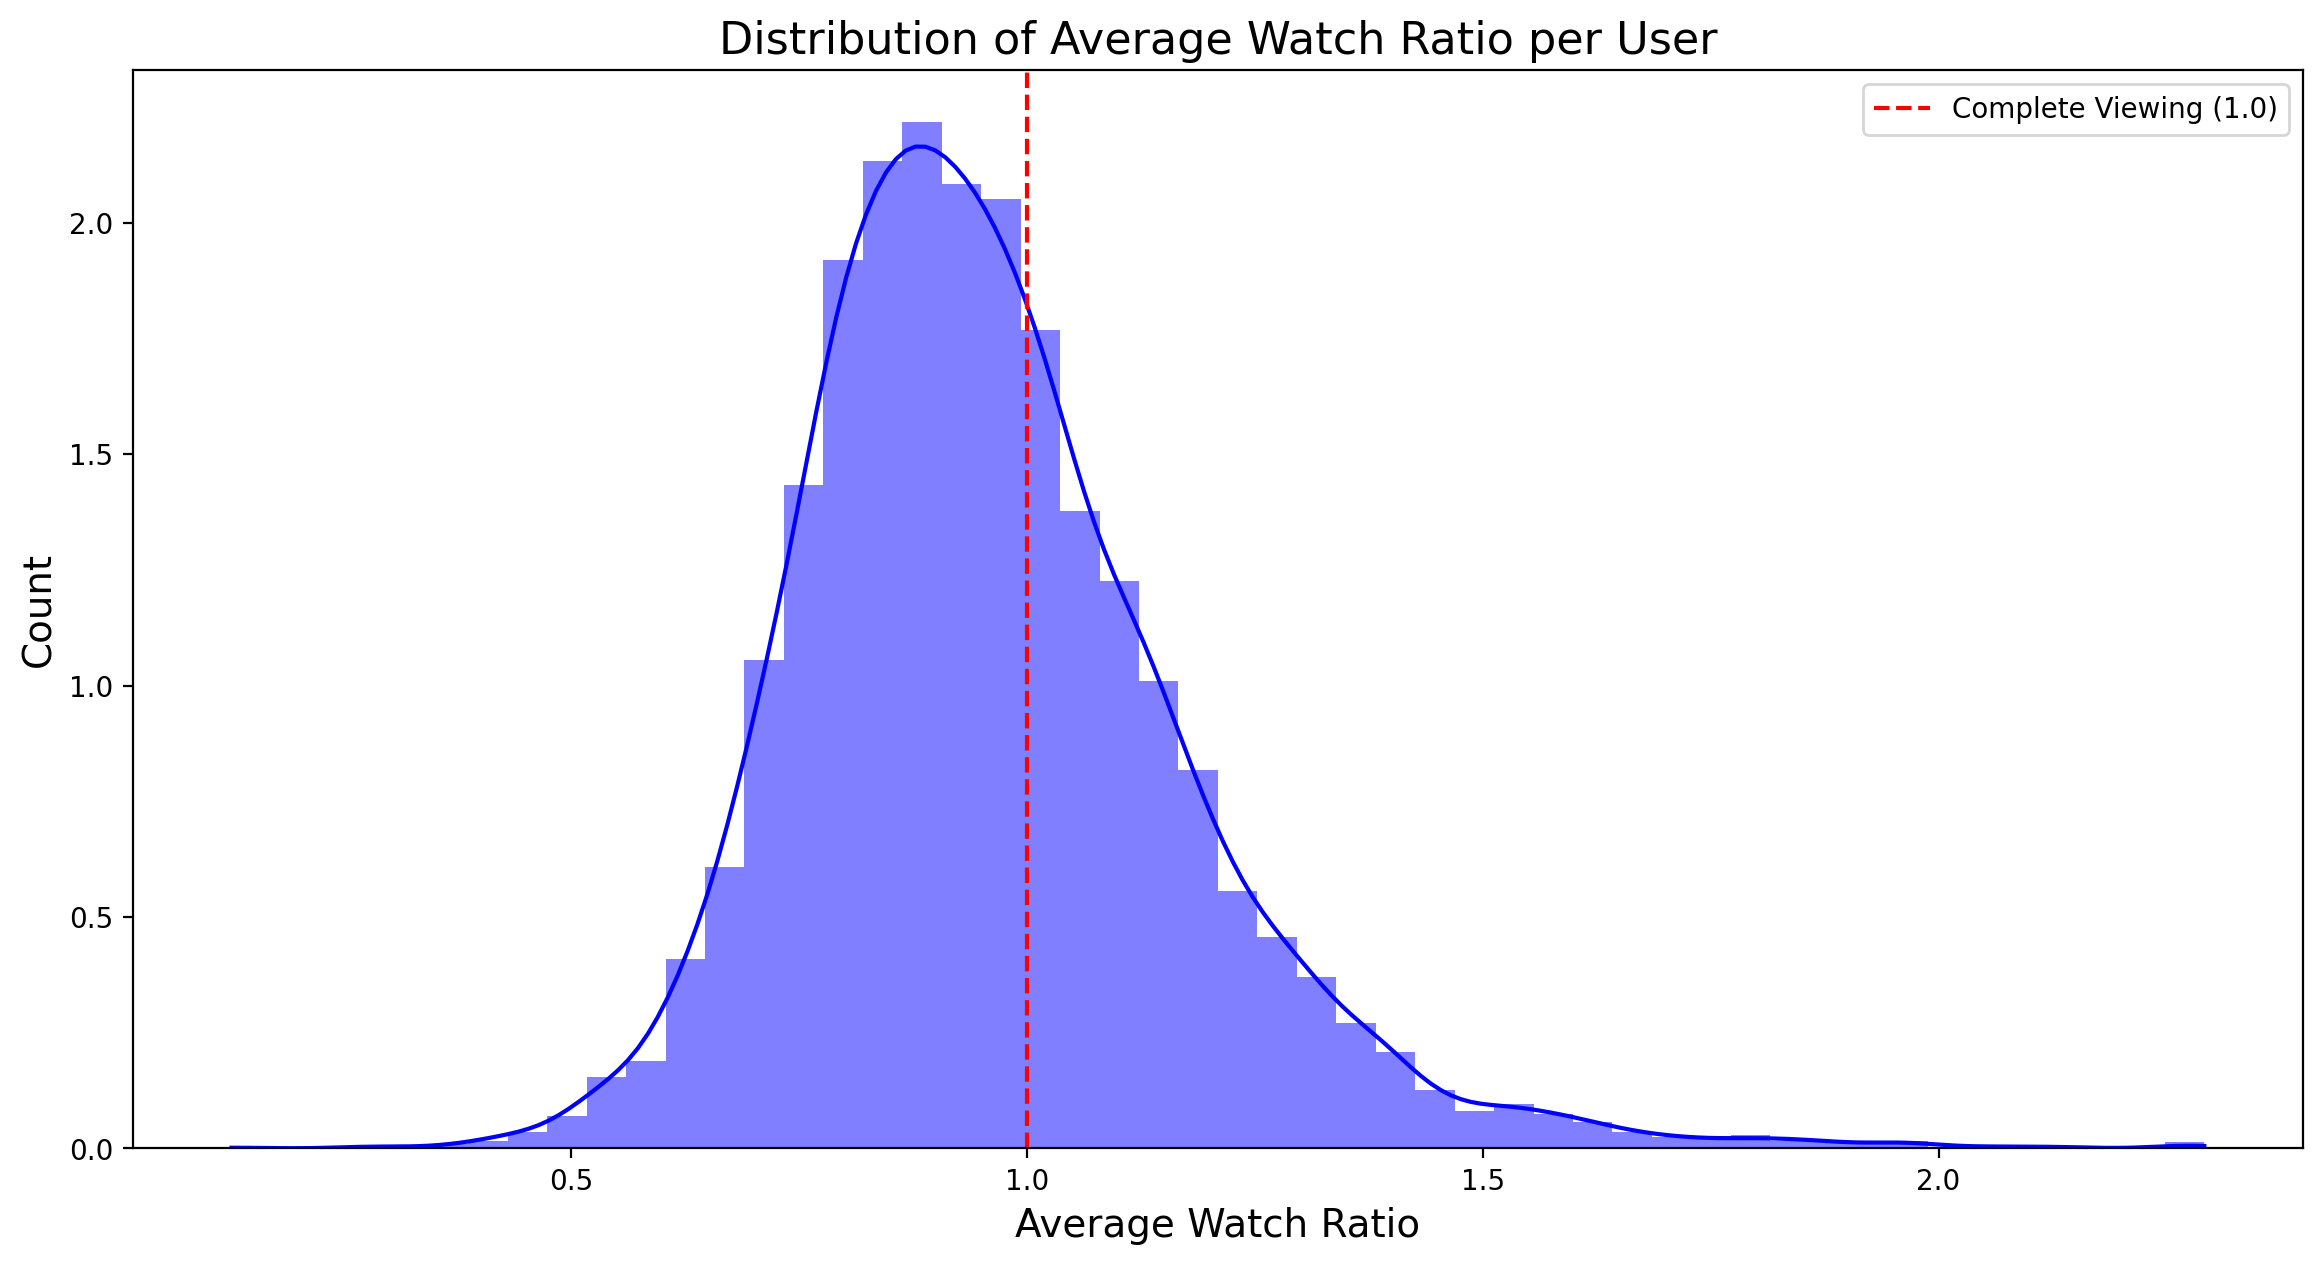

Median watch ratio: 0.93
Percentage of users with average watch ratio > 1.0: 36.50%


In [5]:
# Analyze user engagement patterns
plt.figure(figsize=(14, 7))

# Calculate average watch ratio per user
user_watch_ratio = train_data.groupby('user_id')['watch_ratio'].mean().sort_values()

# Plot the distribution
sns.histplot(user_watch_ratio, bins=50, kde=True,color='blue', stat='density', linewidth=0)
plt.title('Distribution of Average Watch Ratio per User', fontsize=16)
plt.xlabel('Average Watch Ratio', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.axvline(x=1.0, color='r', linestyle='--', label='Complete Viewing (1.0)')
plt.legend()
plt.show()

# Calculate statistics on watch behavior
print(f"Median watch ratio: {user_watch_ratio.median():.2f}")
print(f"Percentage of users with average watch ratio > 1.0: {(user_watch_ratio > 1.0).mean()*100:.2f}%")

These results indicate that most users tend to watch a substantial portion of the videos they interact with. The median watch ratio of 0.93 suggests that at least half of the users watch more than 93% of each video on average, reflecting high engagement. Interestingly, 36.5% of users have an average watch ratio greater than 1.0, which may be due to users rewatching parts of videos or replaying them multiple times.

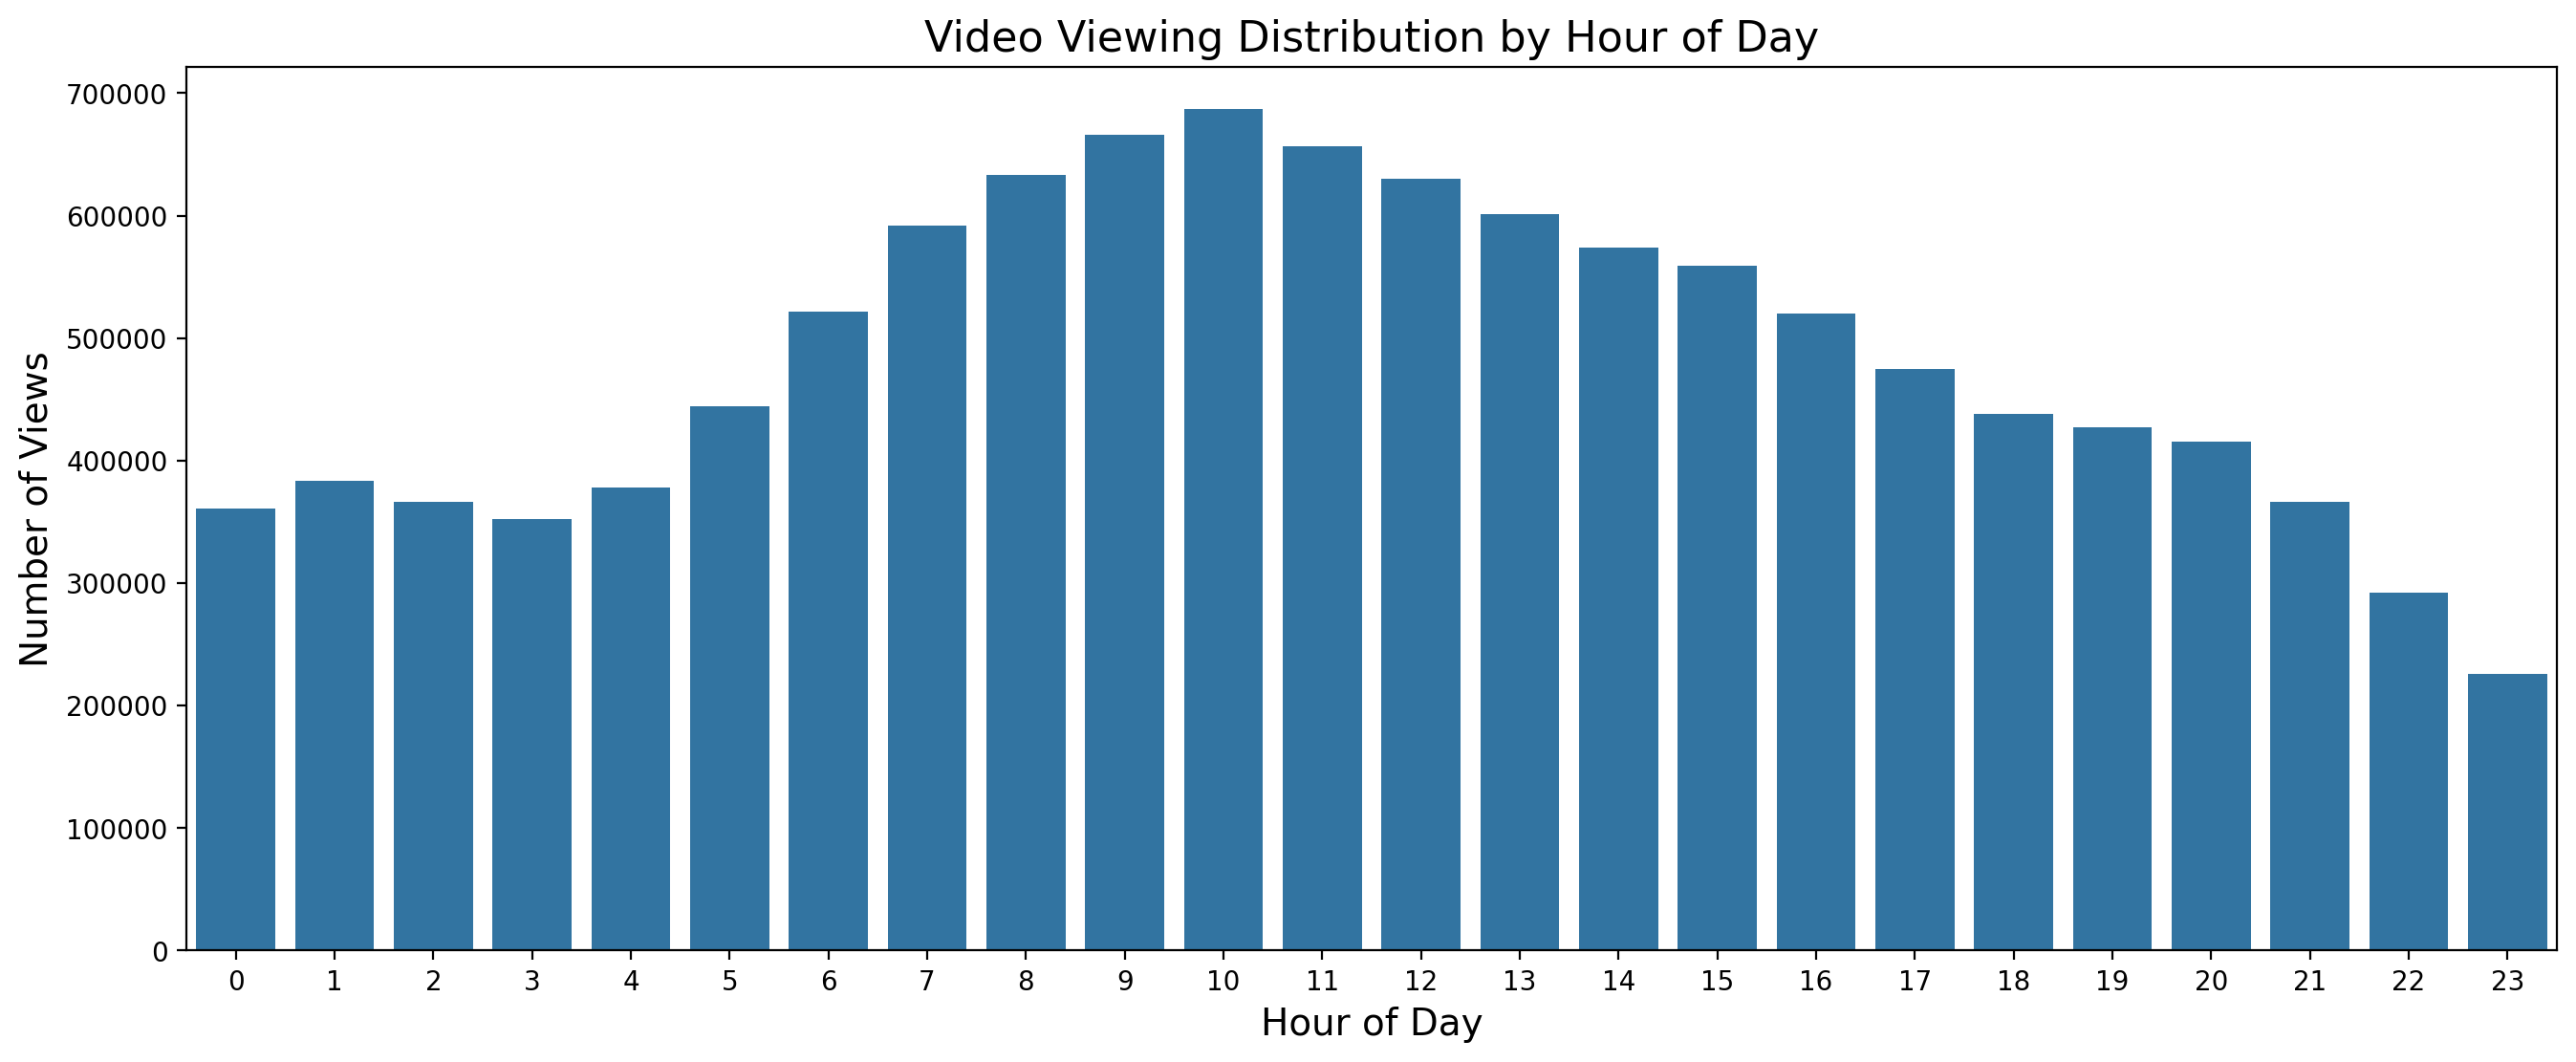

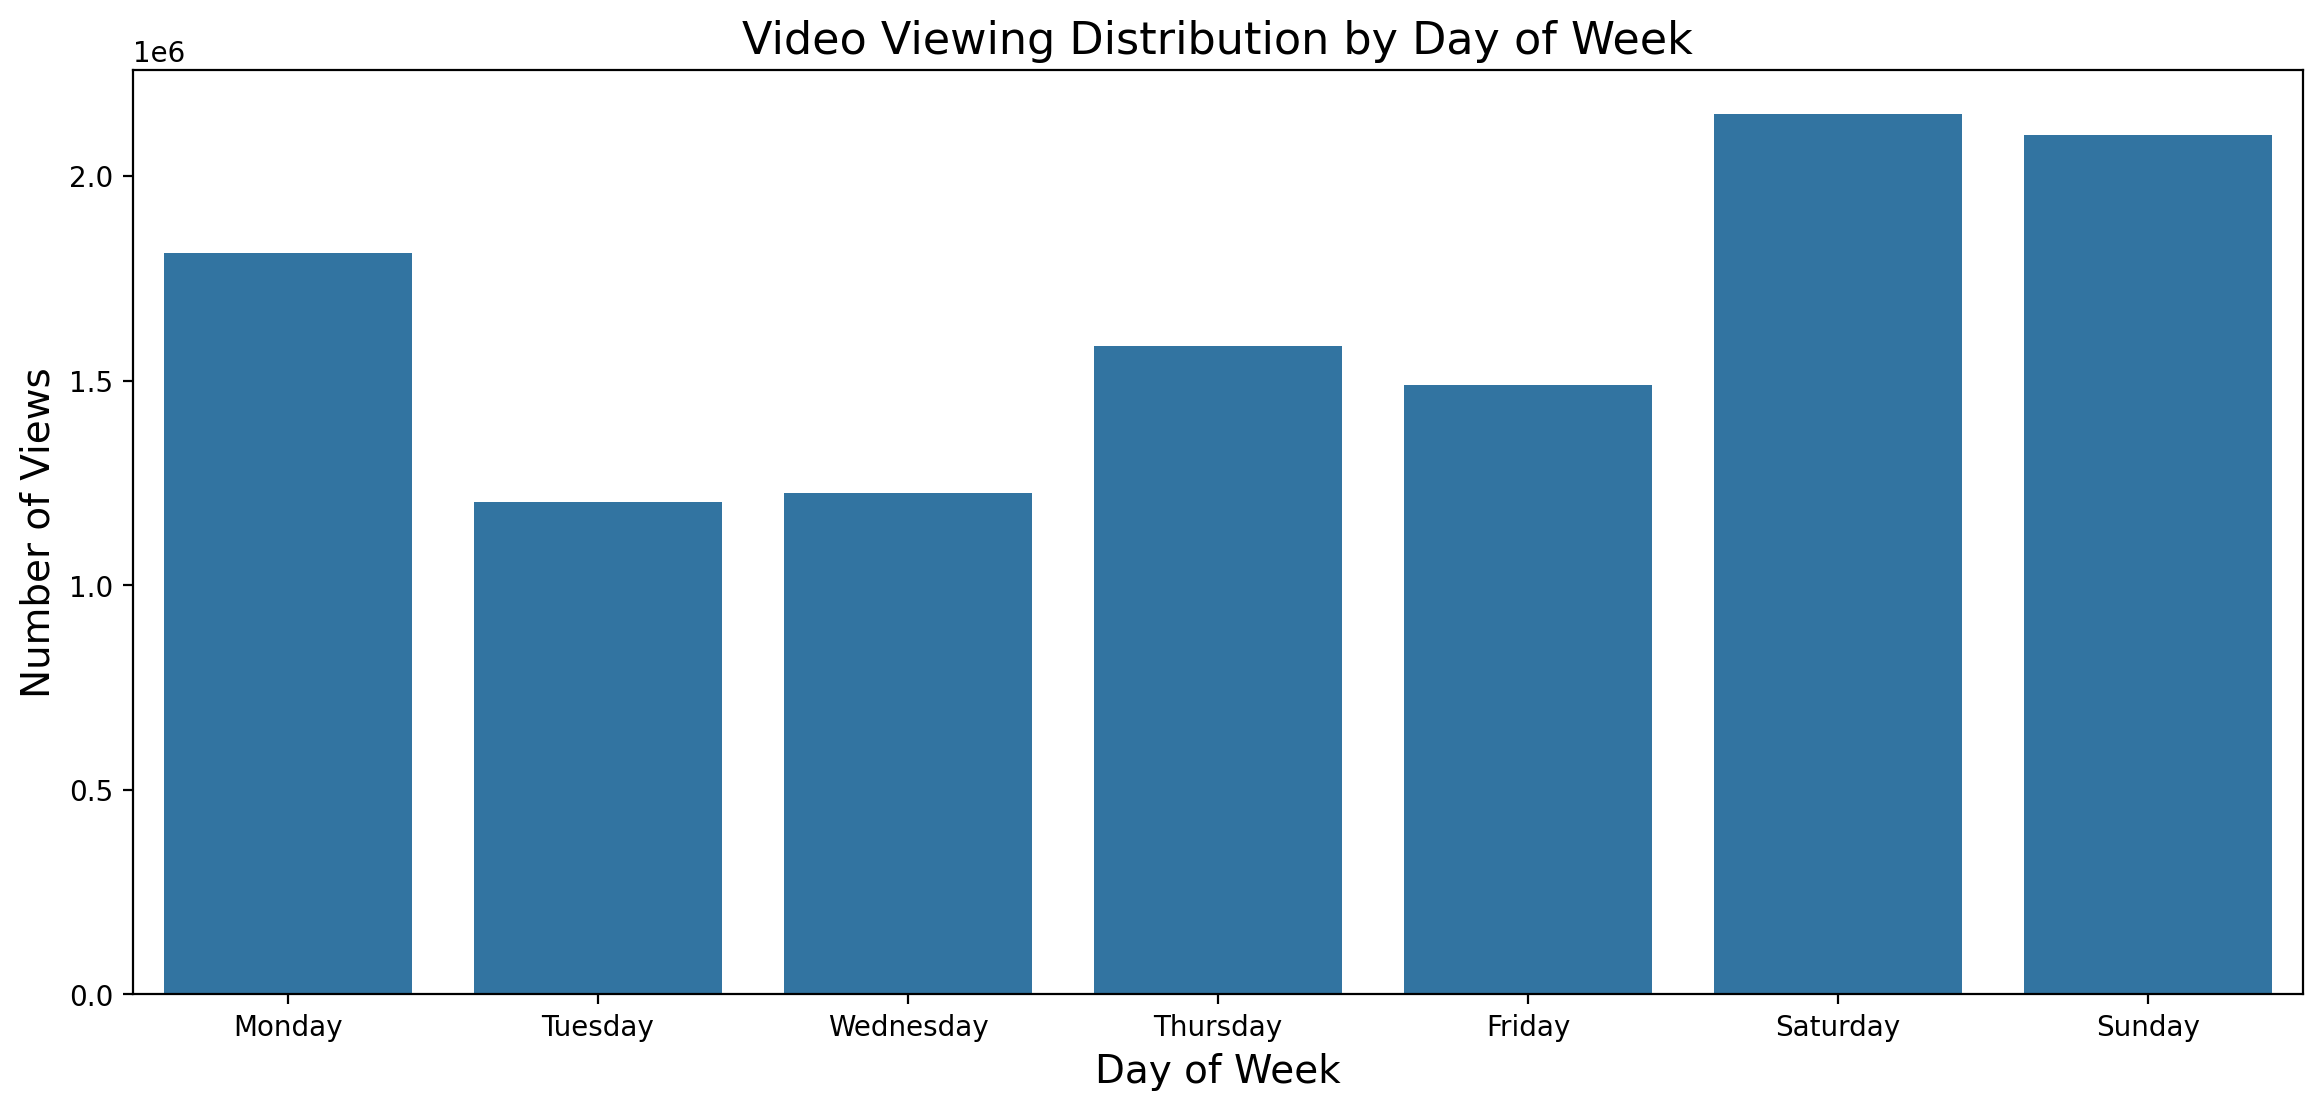

In [6]:
# Convert time to datetime if not already
train_data['time'] = pd.to_datetime(train_data['time'])

# Extract hour of day and day of week
train_data['hour'] = train_data['time'].dt.hour
train_data['day_of_week'] = train_data['time'].dt.dayofweek

# Plot viewing patterns by hour
plt.figure(figsize=(16, 6))
hour_counts = train_data['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Video Viewing Distribution by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Views', fontsize=14)
plt.xticks(range(0, 24))
plt.show()

# Plot viewing patterns by day of week
plt.figure(figsize=(14, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = train_data['day_of_week'].value_counts().sort_index()
sns.barplot(x=[day_names[i] for i in day_counts.index], y=day_counts.values)
plt.title('Video Viewing Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Views', fontsize=14)
plt.show()

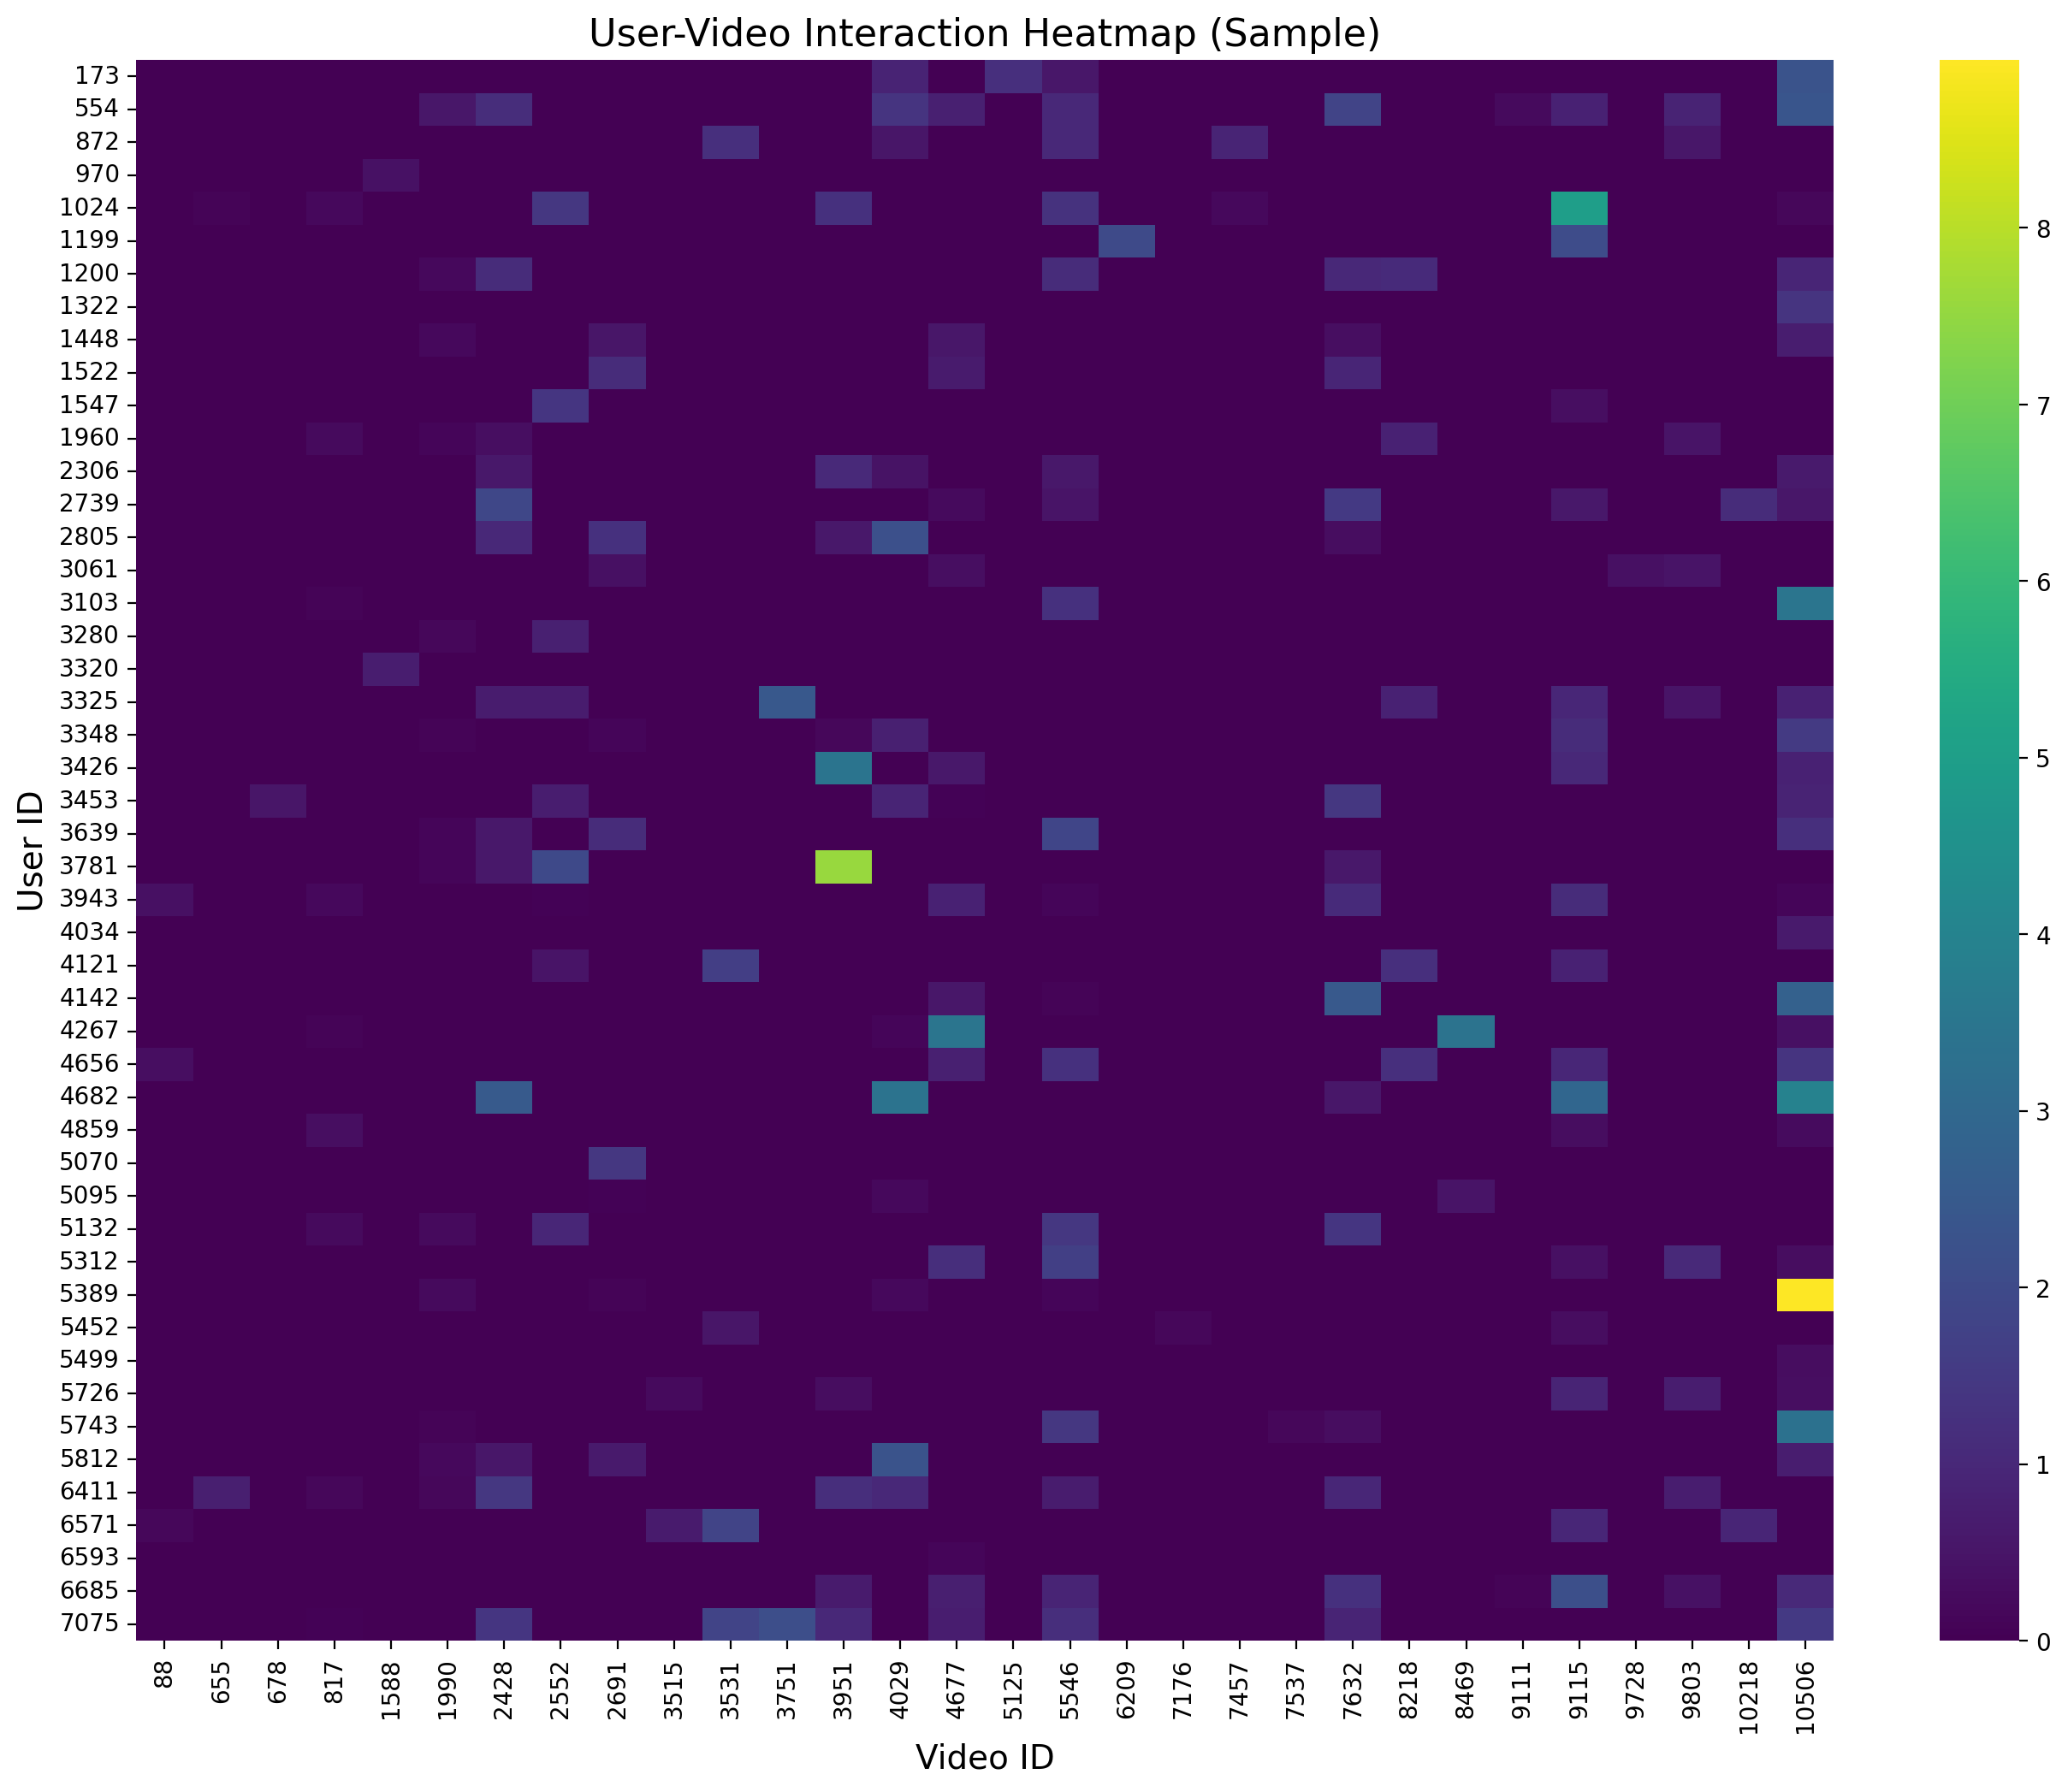

Interaction matrix sparsity: 0.8498 (84.98%)


In [ ]:
# Create a pivot table of user-item interactions
user_sample = np.random.choice(train_data['user_id'].unique(), size=50, replace=False)
video_sample = np.random.choice(train_data['video_id'].unique(), size=50, replace=False)

# Filter the data for these samples
sample_data = train_data[(train_data['user_id'].isin(user_sample)) & 
                          (train_data['video_id'].isin(video_sample))]

# Create interaction matrix
interaction_matrix = sample_data.pivot_table(
    index='user_id', 
    columns='video_id', 
    values='watch_ratio', 
    aggfunc='mean',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(interaction_matrix, cmap='viridis')
plt.title('User-Video Interaction Heatmap (Sample)', fontsize=16)
plt.xlabel('Video ID', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.show()

# Calculate sparsity
sparsity = 1 - (len(train_data) / (train_data['user_id'].nunique() * train_data['video_id'].nunique()))
print(f"Interaction matrix sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")

This heatmap of user-video interactions visualizes how intensively a sample of users engages with various videos, based on the watch ratio. We can see for example that one of the most important interactions is between user_id 5389 and video_id 10506.

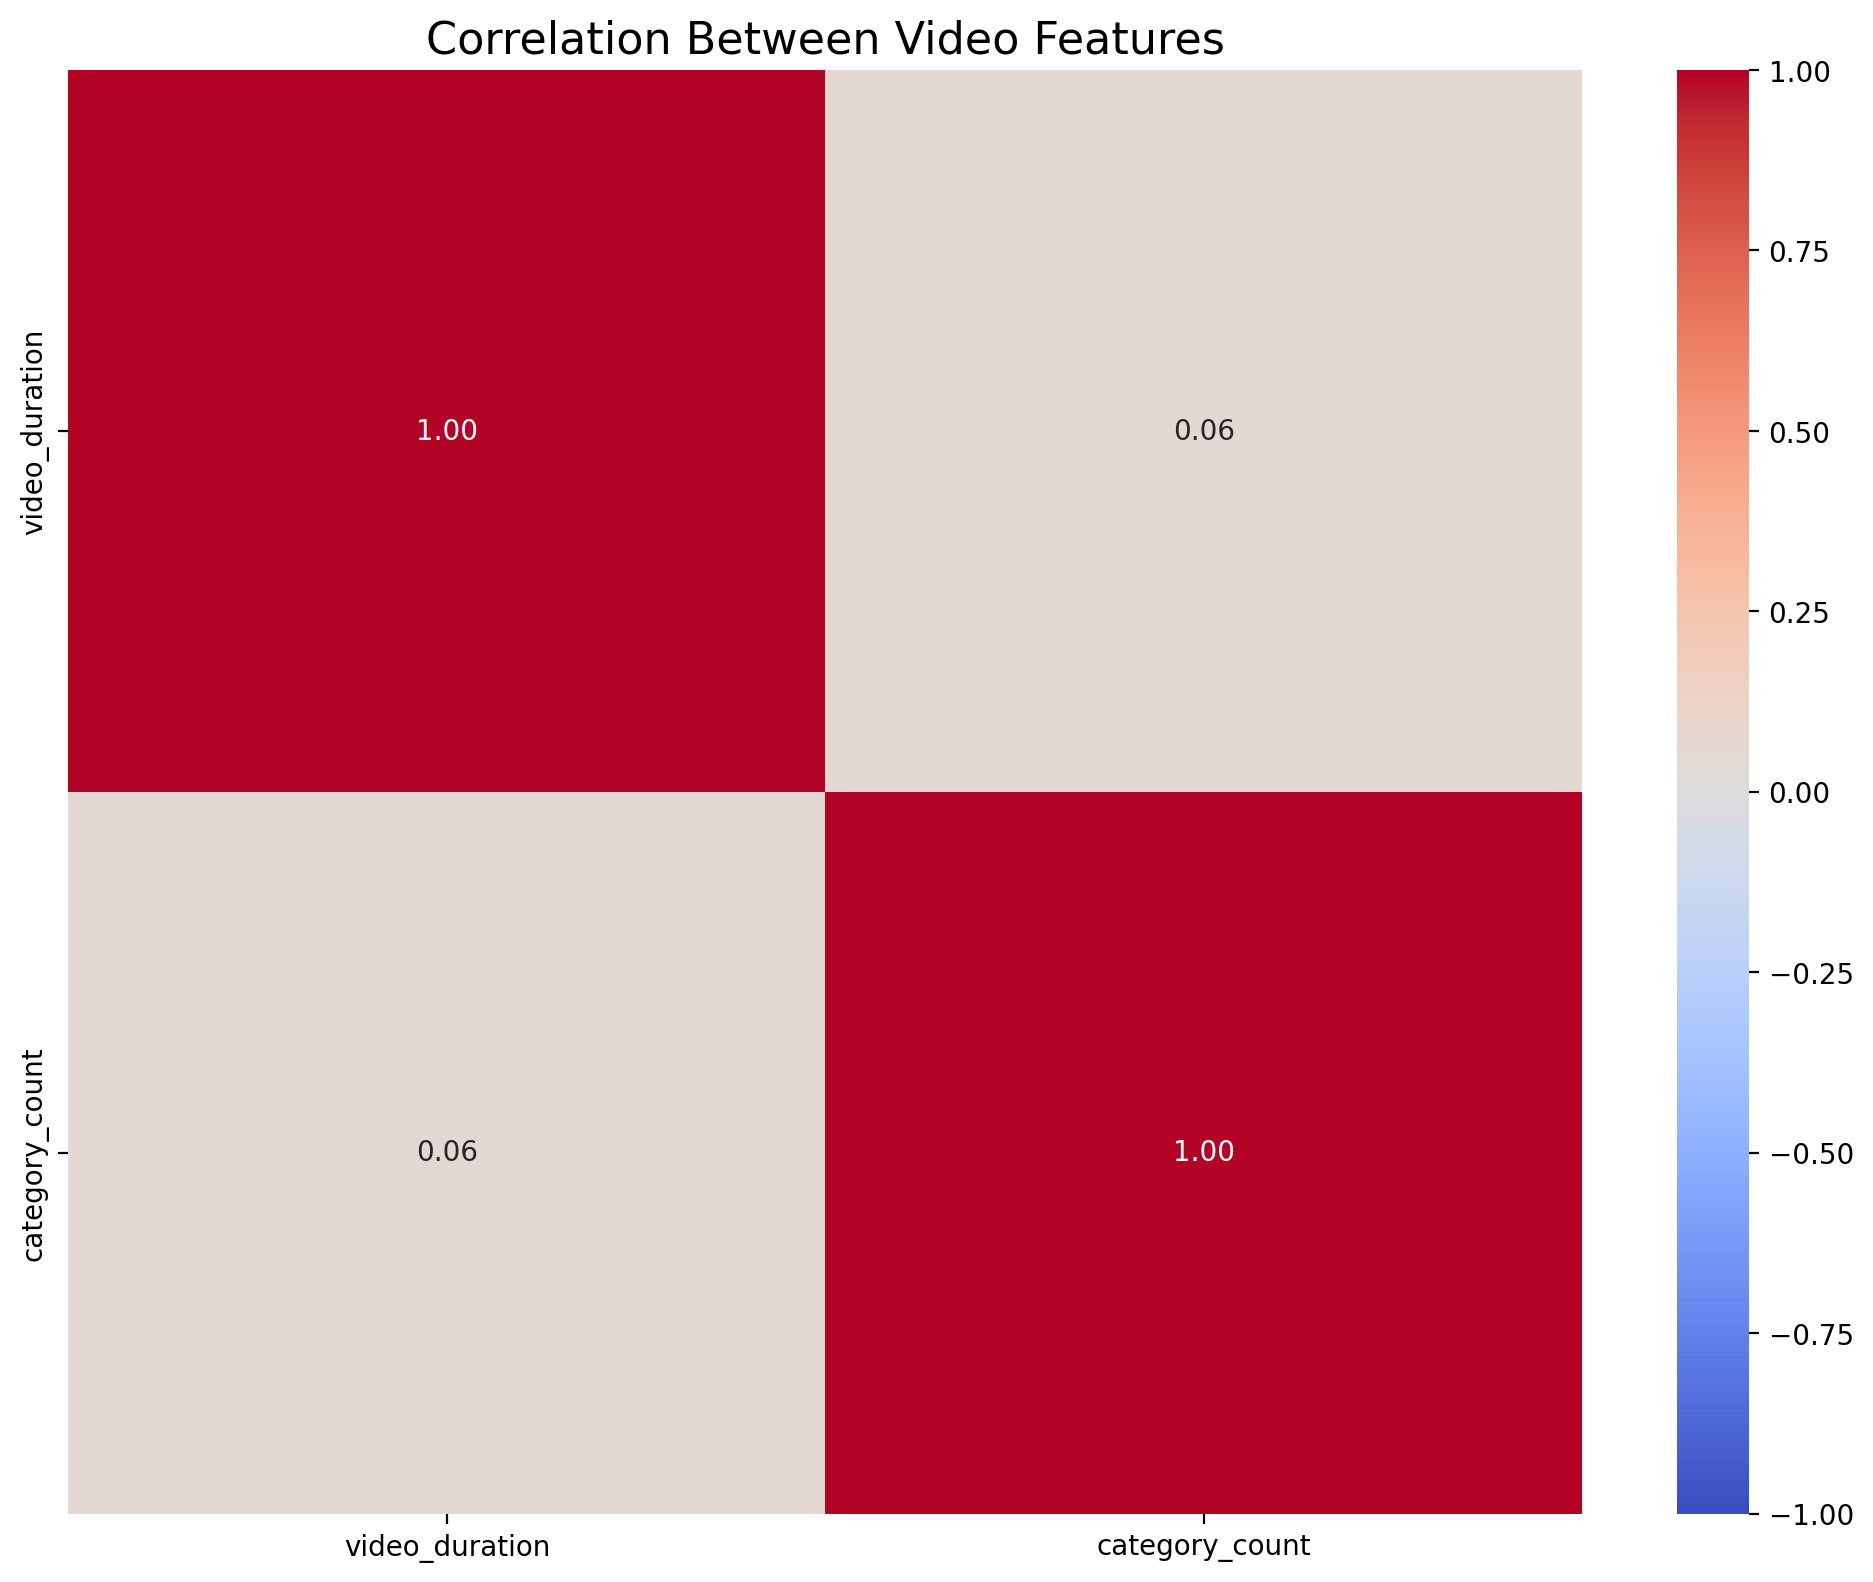

In [8]:
# Calculate correlation between video features
video_features = items.copy()
video_features['category_count'] = categories.iloc[:, 1:].sum(axis=1).values

# drop non-numeric columns
video_features = video_features.select_dtypes(include=[np.number])

# Fill NaN values with 0
video_features.fillna(0, inplace=True)

# Calculate correlation
correlation = video_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Between Video Features', fontsize=16)
plt.tight_layout()
plt.show()

We finally observe the correlation between the video_duration and the category of the video. The score is of 0.06 which indicates a weak correlation. This suggests that the category of the video does not significantly influence its duration. As we have seen above, the mean duration of videos is around 12628 milliseconds, which is approximately 12.6 seconds. This duration is relatively short, indicating that the videos are likely designed for quick consumption, possibly in a social media context where users prefer shorter content. This implies that the category of the video does not significantly influence its duration, and that the platform may prioritize short, engaging content across various categories.